In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
from matplotlib import rcParams,font_manager
from matplotlib.colors import ListedColormap
import pandas as pd

In [2]:
rcParams['figure.figsize'] = (6,6) #figure size in inches
rcParams['font.family'] = "sans-serif" 
rcParams['font.weight'] = "roman" 
rcParams['font.style'] = "normal" # not 100% sure what this does but it was recommended
rcParams['font.size'] = 32 # not 100% sure what this does but it was recommended
rcParams['pdf.fonttype'] = 42
rcParams['axes.linewidth'] = 2 #thickness of the border
rcParams['xtick.major.width'] = rcParams['axes.linewidth'] # make sure line widths are consistent
rcParams['ytick.major.width'] = rcParams['axes.linewidth']
rcParams['axes.spines.right'] = False #hides right border
rcParams['axes.spines.top'] = False #hides top
rcParams['legend.frameon'] = False #hides box around the legend
rcParams['legend.fontsize'] = 18 #font size in pt
rcParams['axes.labelsize'] = 32 
rcParams['xtick.labelsize'] = 24
rcParams['ytick.labelsize'] = rcParams['xtick.labelsize']
rcParams['lines.linewidth'] = 3
rcParams['xtick.major.size'] = 5
rcParams['lines.markersize'] = 16
rcParams['ytick.major.size'] = rcParams['xtick.major.size'] 

usernames = ['A112:R_1DSHShmupLFd4m9','A101:R_Q0Jd5lCBrQu5Dm9', 'A121:R_3j2tErwVrBPXWAH', 
             'A1083:R_0OFsszTuxG152et', 'A103:R_3lJsCIPqfpqRhkf', 'A130:R_zUdkqlxVsz3sXcJ',
            '101:R_31SM3mwQvAhBwar', '102:R_vdABJ1XvXNriwff', '107:R_2ahKzS67s2u094R',
            '117:R_2XpQzVOPaMJjkCo', '121:R_2zoxitKzRuYUblm', '129:R_2q8z9DfvMUHDZio',
            '139:R_1F5MGuZ2rKZOLnc', '152:R_XEQd4AtPvWuAWnT', '149:R_shhEOP9BPIFkz97', '150:R_3ilNhJufw9u0JJr',
            '156:R_2TTetTXWqRwQOGb', '166:R_9Nac2hjg6u7BlS1', '137:R_2X1ycnpBX7zJOwI',
            '256:R_10BfVTQovUcZioM', '175:R_2vjnTMhG0Bpa7wq', '181:R_3fDgQlApbcv1n4e',
            '187:R_3oHOHstFKN4HiLA', '192:R_1LeQOpZ9pat1k7D', '199:R_D1Afhly6eOCY66B',
             '201:R_3kzZPXnjFGbpt30', '202:R_2OHMsGSLXJZG0Bc', '200:R_1NCzjmN3Hl5r3HF',
             '194:R_24rdiskqYQc7BsO', '196:R_0voL9dLPRpILrS9', '197:R_bqny5leXGykyp0t',
             '179:R_2xV1IwgJyplwuvp', '180:R_1OGFPUUh0z8rWBh', '250:R_r2BwOdT2hnmQ5WN',
             '273:R_2zuodaGDxpO8dfe', '281:R_NVGtaI93MLLVQfT', '290:R_25zHKt5eqk2Fr1k',
             '305:R_WBOZ0yrZfLTCClz', '842:R_3jciZNiYxaSffqd',
             '846:R_z1hBUlYMwkfdbGh', '844:R_2D6PtBpvztH0yVh', '849:R_1im5d5ENT1vk0Xm',
             '856:R_3EEYoLyNN9SpuuT', '149:R_shhEOP9BPIFkz97', '150:R_3ilNhJufw9u0JJr',
             '156:R_2TTetTXWqRwQOGb', '166:R_9Nac2hjg6u7BlS1', '137:R_2X1ycnpBX7zJOwI',
             
            '859:R_2TIcY7St40mDSbp', '832:R_xlnbFfl5i6Zgz5v',
            '858:R_3NR4vGxEweQ74vU', '833:R_1IsH6cT55Ys9Qu4', '834:R_30ppJhWfEZIOoSi', '182:R_3NEgCFlK1BFSmdZ',
            '183:R_2uPQbPniskmS0Ep', '208:R_2AST2XkjQUqflkc', '212:R_OOl4OrOpRgbrLBD', '215:R_32R47f1GRrLhRdX',
            '228:R_ULyuWg2JwZBuGiJ', '245:R_eINRkRhqhKHRjzz', '231:R_2QRpawEy8w6txvN', '226:R_2X10rcLujzFpHxv', 
            '236:R_24qFUPTZKx0SybQ', '249:R_d1i4xMt2Vzivxg5', '216:R_21j62EoiJ63yEJ5', '217:R_1JPc2llYzw1ezqs',
            '227:R_2qlLx30lmNEXUJL', '230:R_28G5rUmynDONqbJ', '209:R_1esokoelkIOTy89', '242:R_12lQaNUgCpqQizh',
            '248:R_1Do3QQWN7pWkPwQ', '171:R_1Qck2ykGDls2DLz', '221:R_2wvlbfkxX6e4M29', '229:R_3KxYOzYEKloODvs']

psiturkid2username = {username.split(":")[1]: username for username in usernames}
studyid2username = {username.split(":")[0]: username for username in usernames}
username2studyid = {username: username.split(":")[0] for username in usernames}
username2psiturkid = {username: username.split(":")[1] for username in usernames}

In [3]:
# Subject numbers appear in fitter parameter folder names
username2subjectnrs = {}
subjectnr2username = {}
for i in range(len(usernames)):
    username = usernames[i]
    subjectnr = i + 1
    username2subjectnrs.setdefault(username, []).append(subjectnr)
    subjectnr2username[subjectnr] = username
repeated_subject_nrs = []
for nrs in username2subjectnrs.values():
    if len(nrs) > 1:
        repeated_subject_nrs.extend(nrs[1:])
repeated_subject_nrs

[44, 45, 46, 47, 48]

In [4]:
datadir = "../data/"
# datadir = "/Users/ilima/Google Drive/Projects/Cate Hartley Weiji/4inarow_fitting_data/"
age = pd.read_csv(datadir + "SubjectAge.csv")
pwm = pd.read_csv(datadir + "params_with_metrics.csv").rename(columns = {"0": "subject_nr", "1": "split"})
dur = pd.read_csv(datadir + "gameDurations.csv")
rts = pd.read_csv(datadir + "reactiontimes.csv")
elo = pd.read_csv(datadir + "elo_ratings.csv")

bins = [7, 12, 18, 26]
age["username"] = age["StudyID"].apply(lambda id: studyid2username.get(id, "-"))
age["username"] = age["StudyID"].apply(lambda id: studyid2username.get(id, "-"))
age['ageBin'] = pd.cut(age['FlooredAge'], bins)
age['ageBinNr'] = age['ageBin'].cat.codes
elo['username'] = elo['psiturkid'].apply(lambda id: psiturkid2username.get(id, "-"))
dur["MainDurationMinutes"] = pd.to_numeric(dur["MainDurationSeconds"]) / 60
dur["TotalDurationMinutes"] = pd.to_numeric(dur["TotalDurationSeconds"], errors='coerce') / 60
rts["TotalMoves"] = rts["UserMoves"] + rts["OpponentMoves"]
metrics = pwm.loc[:,("subject_nr", "split", "planning depth", "feature drop rate", "heuristic quality")]
metrics.loc[:,"username"] = metrics["subject_nr"].apply(lambda nr: usernames[nr - 1])
metrics = pd.merge(metrics, age, on="username", how="left")
metrics = pd.merge(metrics, elo, on="username", how="left")
metrics = metrics[~metrics["subject_nr"].isin(repeated_subject_nrs)] # drop repeated subjects
metrics

,subject_nr,split,planning depth,feature drop rate,heuristic quality,username,StudyID,Gender,ExactAge,FlooredAge,ageBin,ageBinNr,psiturkid,elo
0,1,1,8.13583,0.436090,0.638619,A112:R_1DSHShmupLFd4m9,A112,F,19.6904,19.0,"(18, 26]",2,R_1DSHShmupLFd4m9,285
1,1,2,2.92211,0.273650,0.559960,A112:R_1DSHShmupLFd4m9,A112,F,19.6904,19.0,"(18, 26]",2,R_1DSHShmupLFd4m9,285
2,1,3,0.04544,0.055475,0.596631,A112:R_1DSHShmupLFd4m9,A112,F,19.6904,19.0,"(18, 26]",2,R_1DSHShmupLFd4m9,285
3,1,4,9.13304,0.162850,0.525318,A112:R_1DSHShmupLFd4m9,A112,F,19.6904,19.0,"(18, 26]",2,R_1DSHShmupLFd4m9,285
4,1,5,0.00000,0.312920,0.616708,A112:R_1DSHShmupLFd4m9,A112,F,19.6904,19.0,"(18, 26]",2,R_1DSHShmupLFd4m9,285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,74,1,6.92550,0.141220,0.494260,229:R_3KxYOzYEKloODvs,229,F,11.5014,11.0,"(7, 12]",0,R_3KxYOzYEKloODvs,295
366,74,2,8.48107,0.227380,0.540146,229:R_3KxYOzYEKloODvs,229,F,11.5014,11.0,"(7, 12]",0,R_3KxYOzYEKloODvs,295
367,74,3,4.94710,0.278730,0.490209,229:R_3KxYOzYEKloODvs,229,F,11.5014,11.0,"(7, 12]",0,R_3KxYOzYEKloODvs,295
368,74,4,1.54808,0.252810,0.466085,229:R_3KxYOzYEKloODvs,229,F,11.5014,11.0,"(7, 12]",0,R_3KxYOzYEKloODvs,295


In [5]:
age_colors = ['#7DE3AC', '#129951','#20382B']
age_labels = ["8 to 12","13 to 17","18 to 24"]

def set_labels(ax, title):
    ax.set_xlabel("Age")
    ax.set_ylabel(title)
    labels = age_labels.copy()
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(labels)
    ax.legend([])
    return ax

def plot_with_errorbars(col, title, df = None):
    if not isinstance(df, pd.DataFrame):
        df = metrics.groupby("subject_nr").mean().reset_index()
    ax = df.groupby("ageBinNr")[col].aggregate(['mean', 'sem']).plot(yerr="sem", color='k')
    size = 300
    df.groupby("ageBinNr")[col].aggregate(['mean']).reset_index().plot.scatter('ageBinNr', 'mean', size, age_colors, ax=ax)
    print(f"{len(df.dropna(subset=[col]))} rows used in this graph")
    set_labels(ax, title)

69 rows used in this graph


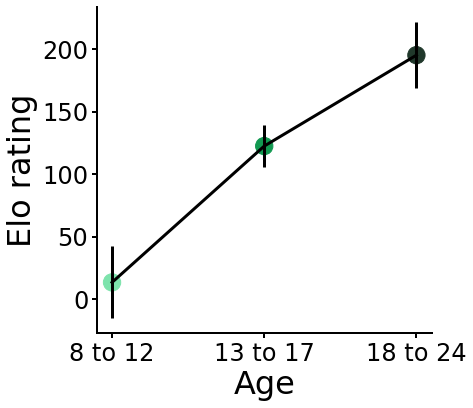

In [6]:
plot_with_errorbars("elo", "Elo rating", pd.merge(age, elo, on="username"))

69 rows used in this graph


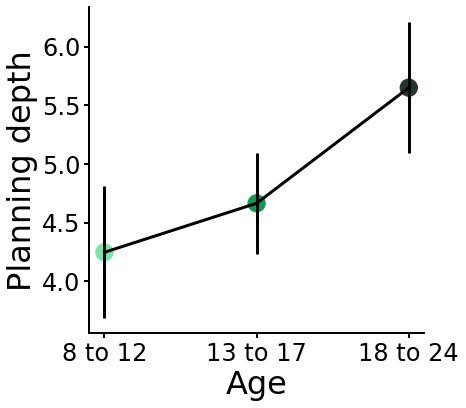

In [7]:
plot_with_errorbars("planning depth", "Planning depth")

69 rows used in this graph


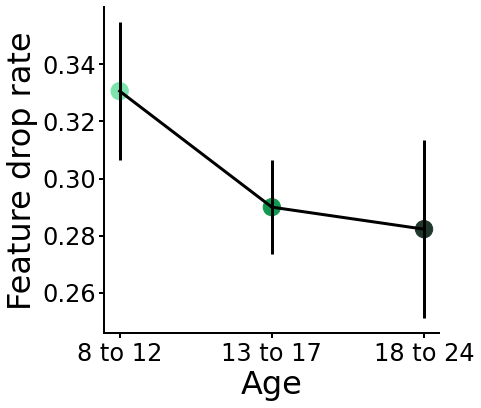

In [8]:
plot_with_errorbars("feature drop rate", "Feature drop rate")

69 rows used in this graph


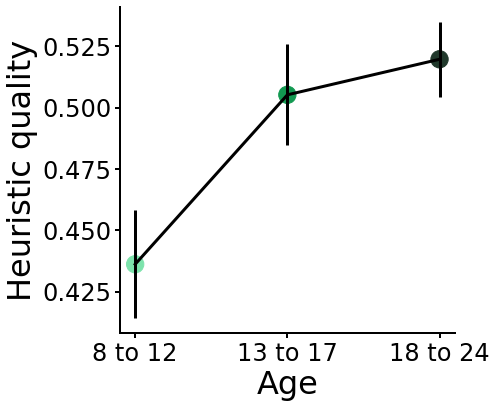

In [9]:
plot_with_errorbars("heuristic quality", "Heuristic quality")

In [10]:
durage = pd.merge(dur, age, how="left", left_on="User", right_on="username")
print(f"Subjects in data: {len(durage)}")
# only include subjects listed in the first cell
durage = durage[durage["User"].isin(usernames)]
print(f"Subjects after selection: {len(durage)}")
# Remove duplicate subjects. Duplicates creep in if on or both of params_with_metrics or the age csv's contains duplicates
durage = durage.drop_duplicates(subset=["User"], keep="first")
print(f"Subjects after filtering duplicates: {len(durage)}")
# Drop subjects for which no age was available. Check that you have the expected number of subjects left!
durage = durage.dropna(subset=["ageBin"])
print(f"Subjects with age bin: {len(durage)}")

Subjects in data: 74
Subjects after selection: 74
Subjects after filtering duplicates: 69
Subjects with age bin: 69


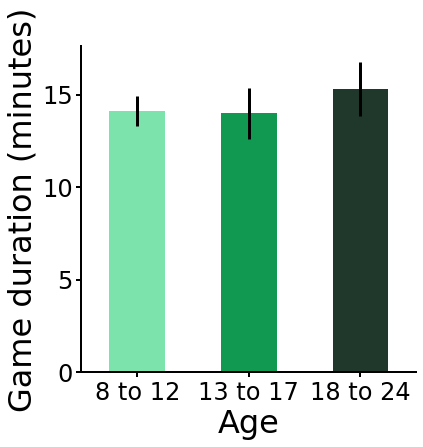

In [11]:
plotdata = durage.groupby("ageBin")["MainDurationMinutes"].aggregate(['mean', 'sem'])
ax = plotdata.plot(kind="bar", yerr="sem", color=[age_colors])
set_labels(ax, "Game duration (minutes)").tick_params("x", labelrotation=0)

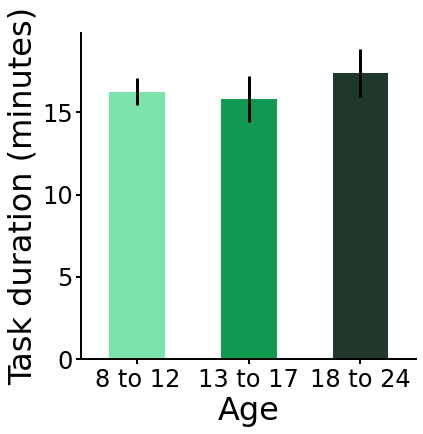

In [12]:
plotdata = durage.groupby("ageBin")["TotalDurationMinutes"].aggregate(['mean', 'sem'])
ax = plotdata.plot(kind="bar", yerr="sem", color=[age_colors])
set_labels(ax, "Task duration (minutes)").tick_params("x", labelrotation=0)

In [13]:
plotdata = pd.merge(rts, age, left_on="User", right_on="username", how="left")[["User", "GameNr", "TotalMoves", "ageBinNr"]].drop_duplicates()
plotdata["count"] = 1
plotdata = plotdata.groupby(["ageBinNr", "TotalMoves"])["count"].sum().reset_index().pivot(index="TotalMoves",columns="ageBinNr").fillna(0)
plotdata.loc[6] = 0
plotdata.loc[37] = 0
plotdata = plotdata.sort_index()

subsPerBin = metrics[["subject_nr", "ageBinNr"]].drop_duplicates().groupby("ageBinNr").count()
for binNr in range(len(bins) - 1):
    plotdata.iloc[:,binNr] = plotdata.iloc[:,binNr] / subsPerBin.iloc[binNr,0]

plotdata

count                    
ageBinNr           0         1         2
TotalMoves                              
6           0.000000  0.000000  0.000000
7           7.757576  7.000000  7.333333
8           4.363636  4.066667  3.000000
9           2.454545  2.933333  2.833333
10          1.818182  2.266667  2.500000
11          2.454545  2.933333  3.333333
12          1.636364  2.400000  2.666667
13          1.787879  2.200000  2.166667
14          1.969697  1.500000  2.166667
15          1.696970  1.800000  0.833333
16          1.242424  1.333333  1.000000
17          1.242424  1.366667  1.333333
18          0.909091  0.633333  1.166667
19          0.818182  0.733333  0.500000
20          0.484848  0.666667  0.666667
21          0.454545  0.433333  1.000000
22          0.454545  0.333333  0.666667
23          0.454545  0.266667  0.166667
24          0.272727  0.333333  0.166667
25          0.454545  0.266667  0.666667
26          0.181818  0.200000  0.000000
27          0.272727  0.100000  0.166667
28          0.121212  0.033333  0.166667
29          0.212121  0.133333  0.166667
30          0.151515  0.033333  0.000000
32          0.060606  0.066667  0.000000
33          0.060606  0.033333  0.000000
34          0.121212  0.000000  0.000000
35          0.030303  0.000000  0.000000
36          1.060606  0.866667  0.333333
37          0.000000  0.000000  0.000000

Text(0, 0.5, 'Average frequency')

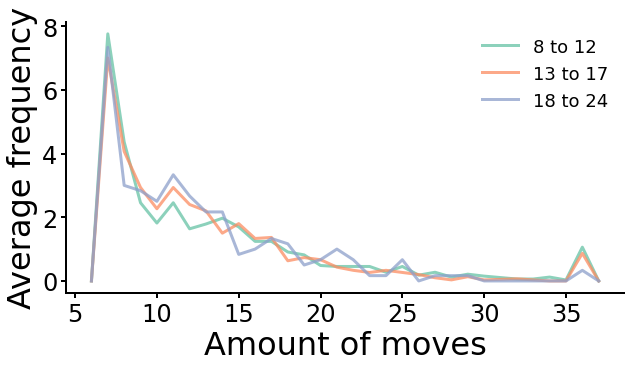

In [14]:
ax = plotdata.plot(color=["#66C2A5C0", "#FC8D62C0", "#8DA0CBC0"], figsize=(10, 5))
ax.legend(age_labels)
ax.set_xlabel("Amount of moves")
ax.set_ylabel("Average frequency")